In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
%cd /content/drive/MyDrive/AML/AML_course/Project

/content/drive/MyDrive/AML/AML_course/Project


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.io
import json
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
import numpy as np
from modules.data_preprocessing import data_reallocation, create_datasets
from modules.train_classfier import train, test_eval
from modules.generate_images import generate_from_prompt


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [44]:
%cd /content

/content


### Data preprocessing

In [4]:
import gdown
url = "https://drive.google.com/drive/folders/1c2xufL1sNJHbQ3v3b5l1jmYx86ahDgLQ"

gdown.download_folder(url, output='flower102')

/content


Retrieving folder contents


Processing file 1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID 102flowers.tgz
Processing file 1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL cat_to_name.json
Processing file 1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn imagelabels.mat
Processing file 1m8mSQlD27WR2vHp-PkiQ_17ts408xn10 setid.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID
From (redirected): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID&confirm=t&uuid=e88693a9-af75-43b8-b664-c86d18375507
To: /content/flower102/102flowers.tgz
100%|██████████| 345M/345M [00:03<00:00, 97.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL
To: /content/flower102/cat_to_name.json
100%|██████████| 2.22k/2.22k [00:00<00:00, 5.09MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn
From (redirected): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn&confirm=t&uuid=4c8dc6d4-c205-4f00-bc98-528a8caf6968
To: /content/flower102/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 620kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1m8mSQlD27W

['flower102/102flowers.tgz',
 'flower102/cat_to_name.json',
 'flower102/imagelabels.mat',
 'flower102/setid.mat']

In [5]:
import tarfile
source_path = "flower102/102flowers.tgz"
destination_path = "flower102"

with tarfile.open(source_path, "r:gz") as tar:
      tar.extractall(path=destination_path)

os.remove(source_path)

In [6]:
# Define paths
data_path = 'flower102'
images_path = os.path.join(data_path, 'jpg')
output_path = 'data'

data_reallocation(data_path,
                  images_path,
                  output_path)

train_dataset, val_dataset, test_dataset = create_datasets(output_path, batch_size=32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Images reallocated successfully to folder data


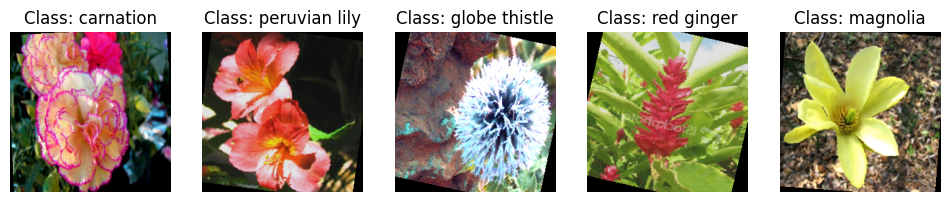

In [7]:
# plot 4 images from data
swapped_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax in axes:
    picture_number = random.randint(0, len(train_dataset))
    image = train_dataset[picture_number][0].permute(1, 2, 0)
    #unnormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    ax.imshow(image)
    ax.set_title(f"Class: {swapped_dict[train_dataset[picture_number][1]]}")
    ax.axis('off')


### Classification model training and evaluation

In [8]:
model = torchvision.models.resnet50(pretrained=True)
num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()
path_to_save_model = 'model.pth'
lr = 0.001
num_classes = len(train_loader.dataset.classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 109MB/s]


Val: Epoch [1/8], n\Loss: 3.7384, n\Accuracy: 23.8235


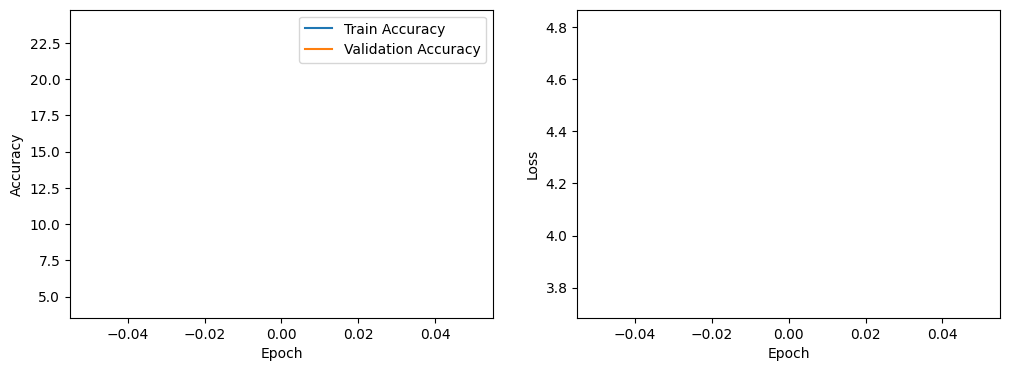

Val: Epoch [2/8], n\Loss: 2.7458, n\Accuracy: 46.9608


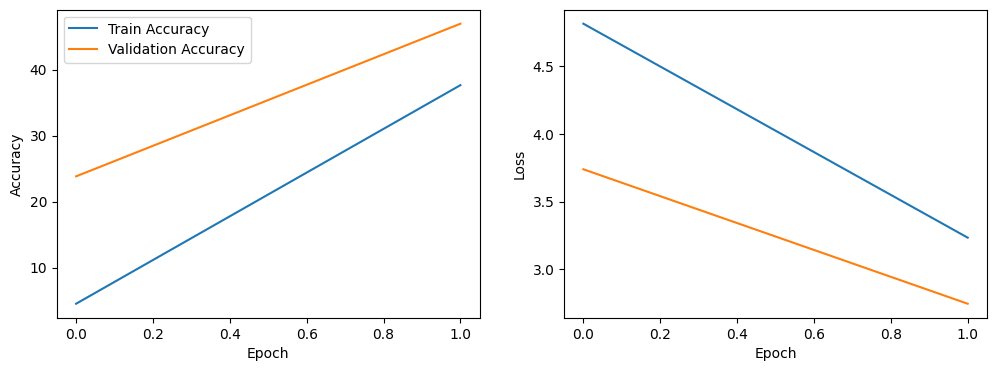

Val: Epoch [3/8], n\Loss: 2.1357, n\Accuracy: 58.6275


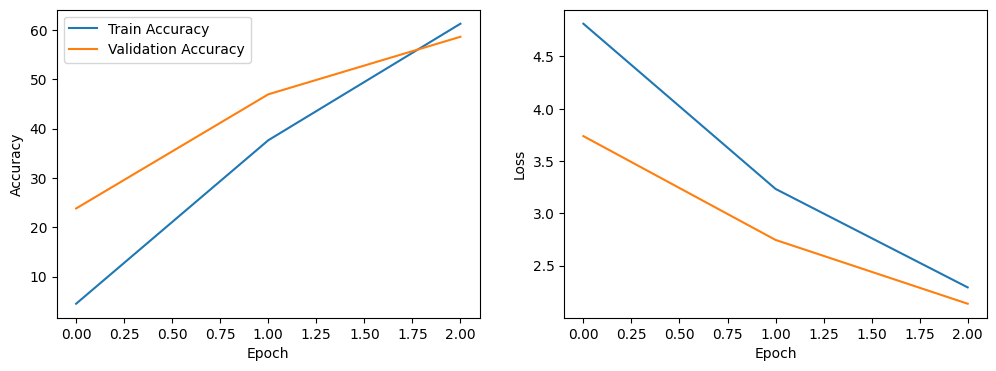

Val: Epoch [4/8], n\Loss: 1.7235, n\Accuracy: 69.9020


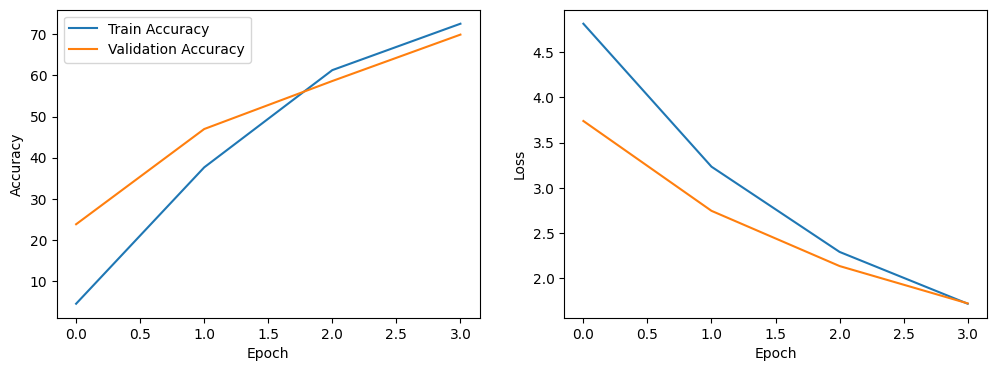

Val: Epoch [5/8], n\Loss: 1.4902, n\Accuracy: 68.5294


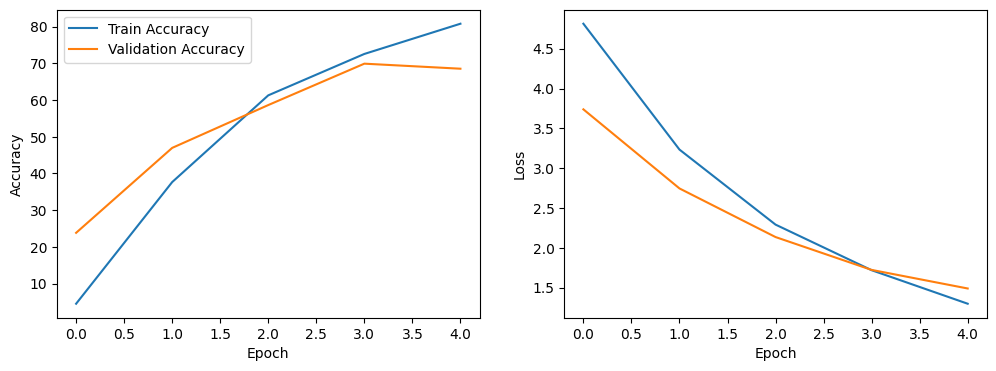

Val: Epoch [6/8], n\Loss: 1.3132, n\Accuracy: 73.1373


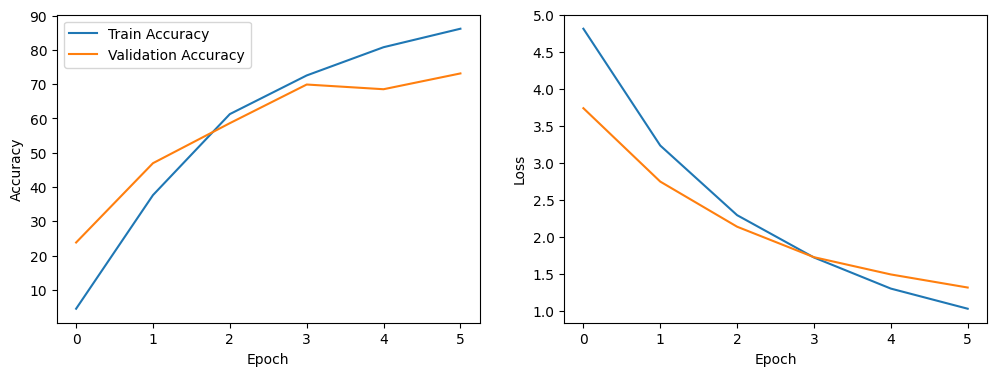

Val: Epoch [7/8], n\Loss: 1.2121, n\Accuracy: 74.6078


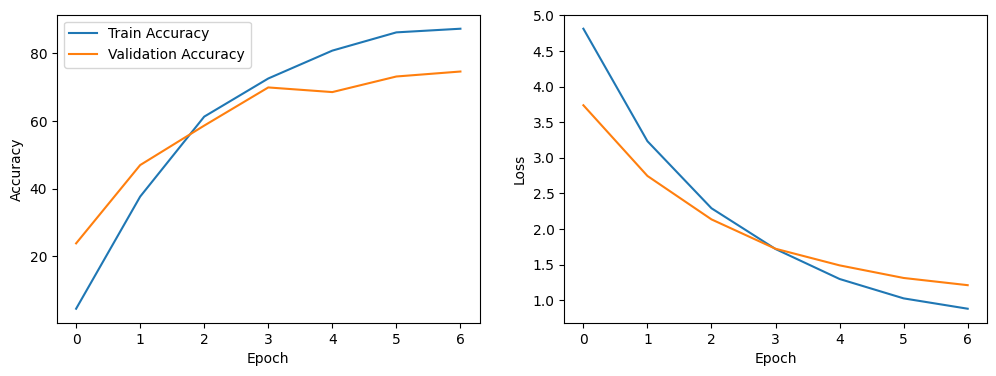

Val: Epoch [8/8], n\Loss: 1.1446, n\Accuracy: 75.0980


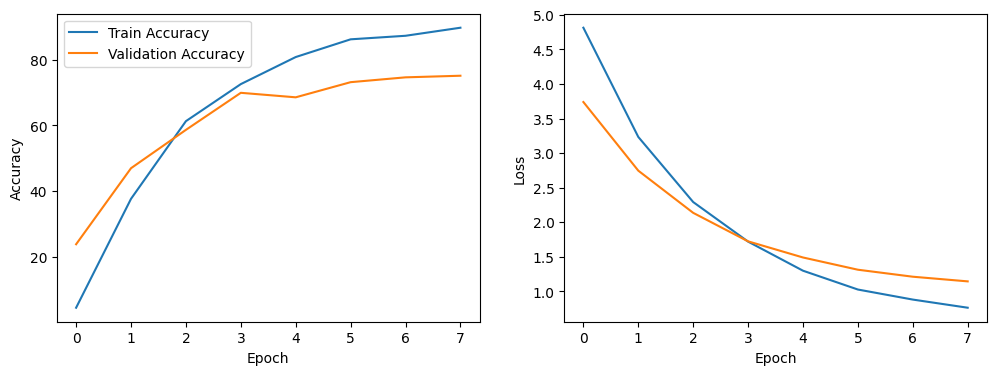

In [9]:
train(train_loader,
      val_loader,
      model = model,
      num_epochs = num_epochs,
      device = device,
      criterion = criterion,
      optimizer = optimizer,
      lr = lr,
      path_to_save_model = path_to_save_model,
      num_classes = num_classes)

In [10]:
test_eval(test_loader,
    model = model,
    device = device,
    path_to_save_model = path_to_save_model)

/content/drive/MyDrive/AML/AML_course/Project/modules/train_classfier.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_save_mod

Test Accuracy: 70.1090


### Worst performing class

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


In [12]:
cm = confusion_matrix(all_labels, all_preds)
class_f1 = []

for i in range(num_classes):
  precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:,i]) > 0 else 0
  recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i,:]) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  class_f1.append(f1)

In [15]:
# Find the class with the worst accuracy and F1-score
worst_class = np.argmin(class_f1)

print(f"Class with worst validation F1: {swapped_dict[worst_class]}, F1: {class_f1[worst_class]}")


Class with worst validation F1: azalea, F1: 0.18181818181818182


In [37]:
indices = np.where(all_labels == worst_class)[0]
preds_worst_class = np.array(all_preds)[indices]
[swapped_dict[i] for i in preds_worst_class]

['hibiscus',
 'canna lily',
 'tiger lily',
 'sweet pea',
 'pink primrose',
 'sweet pea',
 'azalea',
 'hibiscus',
 'canna lily',
 'cape flower']

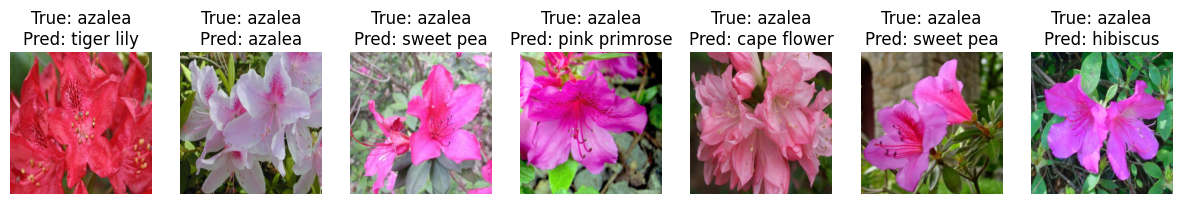

In [33]:
worst_class_indices = [i for i, (img, label) in enumerate(val_dataset) if label == worst_class]

num_images_to_display = 7
selected_indices = np.random.choice(worst_class_indices, size=min(num_images_to_display, len(worst_class_indices)), replace=False)

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    image, label = val_dataset[idx]
    image = image.permute(1, 2, 0)* torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    predicted_label = all_preds[idx]
    axes[i].imshow(image)
    axes[i].set_title(f"True: {swapped_dict[label]}\nPred: {swapped_dict[predicted_label]}")
    axes[i].axis('off')

plt.show()

### Sampling from raw StableDiffusion with prompts

In [38]:
swapped_dict[worst_class]

'azalea'

In [43]:
model_id = "stabilityai/stable-diffusion-2"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [73]:
output_dir = 'raw_model_examples'
os.makedirs(output_dir, exist_ok=True)

generate_from_prompt(model_id = model_id,
                     prompt = f"A close photo of a {swapped_dict[worst_class]}",
                     device = device,
                     output_dir = output_dir,
                     num_images = 10)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_0.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_1.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_2.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_3.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_4.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_5.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_6.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_7.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_8.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examples/a_close_photo_of_a_azalea_9.png


In [74]:
!pip install torcheval
from torcheval import metrics
fid_metric = metrics.FrechetInceptionDistance(device = device)

In [75]:
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Normalize

transform = Resize((299, 299))
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = ToTensor()(image)
    tensor = transform(tensor)
    tensor = normalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

In [76]:
path_to_real_images = os.path.join('data/val', swapped_dict[worst_class])
path_to_real_images_train = os.path.join('data/train', swapped_dict[worst_class])

fake_images = torch.stack([preprocess_image(os.path.join(output_dir, filename)) for filename in os.listdir(output_dir)])
real_images = torch.stack([preprocess_image(os.path.join(path_to_real_images, filename)) for filename in os.listdir(path_to_real_images)])
real_images_train = torch.stack([preprocess_image(os.path.join(path_to_real_images_train, filename)) for filename in os.listdir(path_to_real_images_train)])

fid_metric.update(real_images, is_real=False)
fid_metric.update(real_images_train, is_real=True)
# fid_metric.update(fake_images, is_real=False)

In [77]:
fid_metric.compute()

tensor(162.1312, device='cuda:0')

In [93]:
%cd ../content

/content


In [96]:
output_dir = 'drive/MyDrive/AML/raw_model_examples'

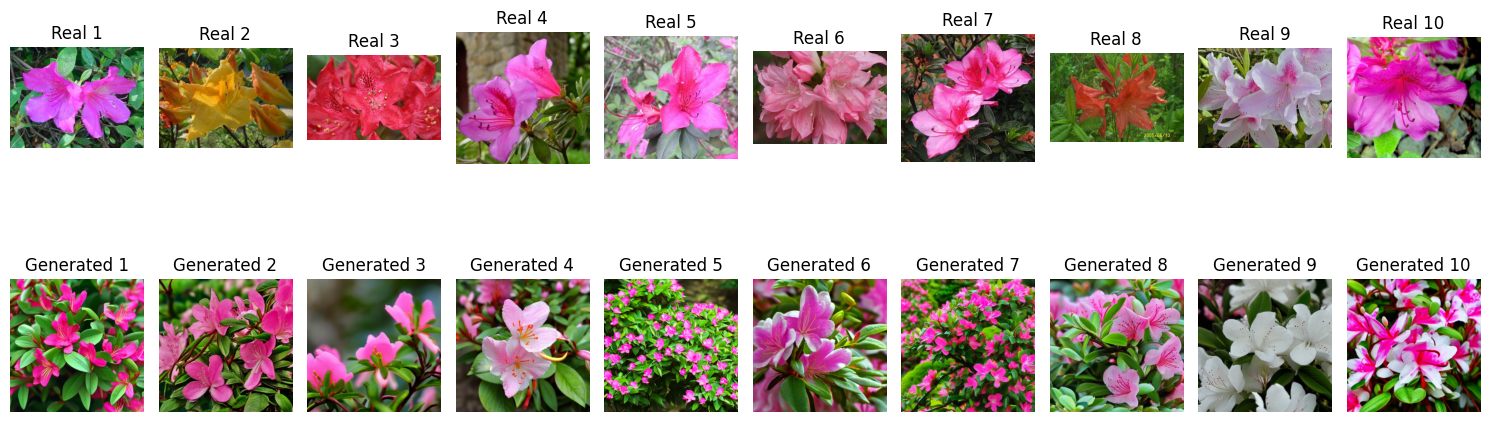

In [97]:

num_images_to_display = min(len(os.listdir(output_dir)), len(os.listdir(path_to_real_images)))
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

# Display real images
for i, filename in enumerate(os.listdir(path_to_real_images)[:num_images_to_display]):
    image_path = os.path.join(path_to_real_images, filename)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Real {i+1}")
    axes[0, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(output_dir)[:num_images_to_display]):
    image_path = os.path.join(output_dir, filename)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Generated {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Textual inversion

In [ ]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [72]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "<cat-toy>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "toy" #@param {type:"string"}

In [ ]:
#@title Setup the prompt templates for training
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [ ]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [ ]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [ ]:
#@title Get token ids for our placeholder and initializer token. This code block will complain if initializer string is not a single token
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [ ]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))

In [ ]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [ ]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [ ]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

In [ ]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [ ]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

In [ ]:
#@title Setting up all training args
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

In [ ]:
#@title Training function
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

In [ ]:
#@title Set up the pipeline
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

In [ ]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "a \u003Ccat-toy> inside ramen-bowl" #@param {type:"string"}

num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid